# Analyzing the Embedding Space of Diffusion Models
The goal of these experiments is to get a sense of how class-conditioned diffusion models "organize" their embedding space. Specifically, we want to visualize the embedding space to see where concepts lie relative to each other. These concepts can arise from hard (class) embeddings or from soft embeddings via inversion. Overall, can we guess at what kinds of features contribute the most to a concept's position in the space? 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from matplotlib.axes import Axes
from scipy.spatial.distance import cdist
import seaborn as sns

## Analyzing vanilla high-dimensional embeddings
Let's start with a vanilla diffusion model trained on MNIST with a 256-dimensional embedding space. The samples from the model looked as follows:

<img src="./embedding_viz_figures/default_model_samples.png">

Now let's load in the embeddings for analysis.

In [2]:
high_dim_embedding_df: pd.DataFrame = pd.read_csv('./embedding_viz_figures/embeddings_256D.csv')
high_dim_embedding_df = high_dim_embedding_df.drop('Unnamed: 0', axis=1)
high_dim_embedding_df.head()

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
0,0.490793,0.119851,0.525441,-0.212172,-0.787417,-0.177324,-0.819218,0.692191,-1.123453,1.403329,...,-0.143425,0.071162,-1.038514,0.272030,-1.148265,0.842183,-0.357676,-0.729616,-0.671234,0.417261
1,0.751272,-0.809994,-0.353494,0.287115,-1.343672,-0.218276,0.601134,-0.627271,-0.893522,-0.243491,...,1.170293,0.355145,-1.016206,0.968395,-0.333482,-1.738884,0.109698,-0.514775,-0.151678,-0.838613
2,-0.231407,-0.140564,0.966674,-0.365095,0.577592,1.595773,1.530895,-0.244343,-0.867114,-1.774926,...,-0.204241,-1.189489,0.242001,-0.046759,0.195439,0.315243,0.795845,0.289535,0.641725,1.192091
3,0.504558,-1.012651,-0.906808,-0.519240,-0.493527,1.238373,-0.037269,0.209305,0.057182,-3.179349,...,0.389220,1.091394,1.237739,0.450629,0.224749,-0.378710,0.343733,2.559378,0.208945,0.641318
4,-0.054420,0.161896,-1.529460,-0.736359,-1.352035,1.355013,0.817067,0.144053,-0.864818,-1.086615,...,1.514718,0.098882,-0.567424,-0.326412,0.270733,0.703914,-0.523867,0.001783,-0.568940,0.560461


In [3]:
high_dim_embeddings: np.ndarray = high_dim_embedding_df.to_numpy()
high_dim_embeddings.shape

(10, 256)

Since it's rather difficult to visualize so few point locations in such a high dimensional space (random projection and PCA can only get you so far, sadly...), let's start by using some matrix analytics to get an idea of the complexity of the relationships between the class embeddings.

First, let's take the singular value decomposition of the embedding matrix to get a sense of its rank. If its singular values suddenly get much smaller in magnitude ($\sigma_{i+1}$ is much smaller than $\sigma_i$ for some $i$), we can say that the embeddings likely lie on some lower dimensional manifold (since a low-rank approximation using the top $i$ singular values/vectors would be relatively accurate as the $i+1$ and so on singular values go to 0). If the singular values stay consistent in magnitude throughout, then we conversely have that the relationship between the embedding points is higher dimensional in nature.

Let's also plot the pairwise distances between the embeddings to see which classes lie closer together and which lie further apart.

I expect that the singular values will likely drop off rather quickly as MNIST classes have a strong degree of feature correlation, so the embedding space will likely exhibit these relationships. Similarly, I definitely expect pairs of similar classes such as 1/7 and 4/9 to lie close to each other; intuitively, it seems like optimization would treat the concepts of 1 and 7, which look relatively similar, in a similar fashion, thus putting them close to each other in the space.

In [4]:
U: np.ndarray; S: np.ndarray; VT: np.ndarray
U, S, VT = np.linalg.svd(high_dim_embeddings)
pairwise_distances: np.ndarray = cdist(high_dim_embeddings, high_dim_embeddings)

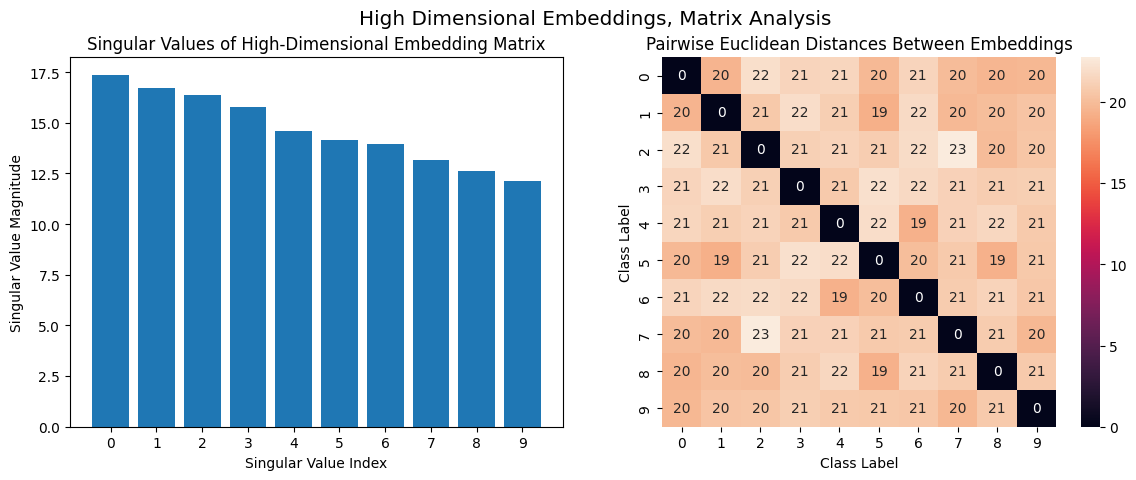

In [5]:
high_dim_fig: Figure; svd_barplot: Axes; distance_heatmap: Axes
high_dim_fig, (svd_barplot, distance_heatmap) = plt.subplots(1, 2)
high_dim_fig.set_figwidth(14)
high_dim_fig.suptitle('High Dimensional Embeddings, Matrix Analysis', size='x-large')
svd_barplot.bar(np.arange(S.shape[0]), S)
svd_barplot.set_xticks(np.arange(S.shape[0]))
svd_barplot.set_title('Singular Values of High-Dimensional Embedding Matrix')
svd_barplot.set_xlabel("Singular Value Index")
svd_barplot.set_ylabel("Singular Value Magnitude")
sns.heatmap(pairwise_distances, ax=distance_heatmap, annot=True)
distance_heatmap.set_title("Pairwise Euclidean Distances Between Embeddings")
distance_heatmap.set_xlabel("Class Label")
distance_heatmap.set_ylabel("Class Label")
plt.show()

That is definitely not what I expected. The singular values have a pretty small range, implying that the embeddings have a rather complex relationship. They also seem roughly equidistant from each other in space, which was surprising. These results could imply that the model may not be using much semantic information (like specific image features) to create these embeddings (perhaps because the embedding space has significantly more dimensions than class embeddings). Instead, it may be performing something closer to memorization, separating the embeddings from each other as much as possible and recreating all of the features from each class separately for each point. Logically, this could result in higher accuracy as it could keep the model from confounding features between different classes as it may if they were close in the embedding space.

We could try to support this hypothesis by seeing if the points seem to lie on some sort of high-dimensional sphere. If they have similar distances to some central point, that could imply that the model is pushing them away from their centroid during training to create more distance between them (and since they were all initialized in a comparatively small radius, they would drift away similarly, creating similar radii and similar distances from each other). Let's calculate the average of the embeddings and calculate the distance from each embedding to this centroid.

In [6]:
centroid: np.ndarray = np.average(high_dim_embeddings, axis=0)
centroid = centroid.reshape((1, centroid.shape[0]))
distances_from_centroid: np.ndarray = cdist(high_dim_embeddings, centroid)

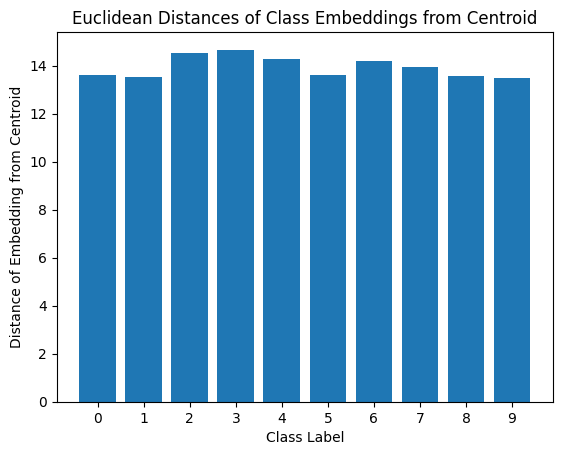

In [7]:
plt.bar(np.arange(distances_from_centroid.shape[0]), distances_from_centroid[:, 0])
plt.xticks(np.arange(distances_from_centroid.shape[0]))
plt.xlabel("Class Label")
plt.ylabel("Distance of Embedding from Centroid")
plt.title("Euclidean Distances of Class Embeddings from Centroid")
plt.show()

Yup! They definitely seem to have relatively similar distances from the centroid, meaning my above explanation could be plausible. Certainly, if they lie on some high dimensional sphere, that explains why their relationship is so high-rank.

Next, let's try constraining the dimensionality of the embeddings to be low, both so we can visualize them and hopefully so the model will make use of specific image features to store the embeddings in a more compact space. Since there are significantly less dimensions for the points to move away from each other, I think each gradient step will have a harder time separating them. Especially at the start of training, when the points are all very close to each other and the model would anyway have trouble partitioning them, I have a feeling that using image features to organize the points will increase model performance more per gradient step than trying to partition the space, meaning the gradient should move in that direction. 

## Visualizing 2D Embeddings
Let's train some 2-dimensional embeddings as these will be easy to visualize. To do this, the model maintained a two-dimensional embedding dictionary that was scaled up to 256 dimensions to be combined with the time embedding. Specifically, it was scaled up in this fashion using matrix multiplication:
$$\begin{bmatrix} a \\ b \end{bmatrix} \rightarrow \begin{bmatrix} a \\ \vdots \\ a \\ b \\ \vdots \\ b \end{bmatrix}$$
The gradient, then, only flowed to $a$ and $b$ in the initial 2D embedding.

Importantly, sample quality was not degraded with this change. They looked as follows:

<img src="./embedding_viz_figures/default_2d_model_samples.png">

Now let's visualize these embeddings too:

In [8]:
low_dim_embedding_df: pd.DataFrame = pd.read_csv('./embedding_viz_figures/embeddings_2D_vanilla.csv')
low_dim_embedding_df = low_dim_embedding_df.drop('Unnamed: 0', axis=1)
low_dim_embedding_df.head()

,0,1
0,0.219238,0.306461
1,0.314240,-0.048906
2,0.134872,0.736293
3,0.402290,-0.792366
4,0.186128,0.592715


In [9]:
low_dim_embeddings: np.ndarray = low_dim_embedding_df.to_numpy()
low_dim_embeddings.shape

(10, 2)

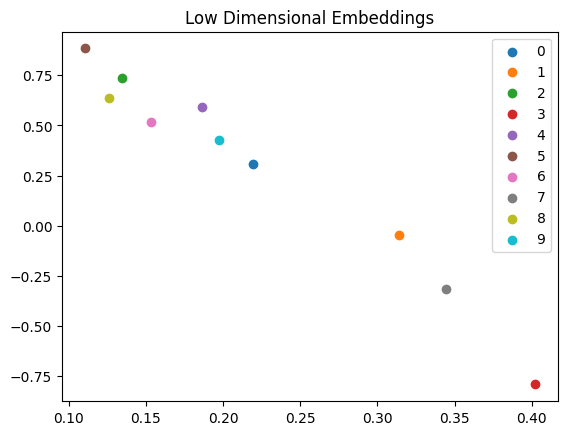

In [10]:
for i in range(len(low_dim_embedding_df)):
    plt.scatter(low_dim_embeddings[i, 0], low_dim_embeddings[i, 1], label=str(i))
plt.title("Low Dimensional Embeddings")
plt.legend()
plt.show()

Wow! It seems to be just as we anticipated. Not only are the points much closer to each other, but they seem to also be organized using some sort of semantic information. Specifically, similar looking numbers like 1/7 and 4/9 are close to each other like we'd hoped, meaning the features used to determine these embeddings could be pretty high-level. I'm surprised that 3 is quite distant from 8 (and from everything else), as they do have some visual similarity, so the relationships between embeddings are definitely more subtle than initially apparent.

Crucially, though, it seems to me like this behavior is a factor of *both* the dimensionality and the number of class embeddings in relation to each other. Certainly, even with a large embedding space, a model with many more hard embeddings to keep track of during training, such as a text-conditioned one, would behave differently than the 256-dimensional MNIST model. Perhaps it would behave more similarly to one with 2D embeddings since it's more difficult to create a significant amount of distance between all of the points quickly at the start of training, or maybe it would be closest to something between 2D/256D. Trying a model with an in-the-middle number of dimensions seems like an interesting next step.

The complexity of the concepts themselves also likely plays a role in this as it may be more difficult to tie all the features of a very complex concept to a specific embedding if the space itself doesn't. This could be resolved by running similar experiments on more complex datasets like CIFAR-10/MS COCO.

First, though, let's explore around the 2D space a little and see where it takes us. Let's start by excluding one class from the dataset and using inversion to search for that missing embedding.

## Visualizing Inverted 2D embeddings

For this section, I trained separate models missing classes 0, 1, and 8 respectively and inverted on the missing class labels for each model. Let's take a look at the samples:

Inverting on 0 generated these samples:

<img src="./embedding_viz_figures/2d_invert_0.png">

Inverting on 1 generated these samples:

<img src="./embedding_viz_figures/2d_invert_1.png">

and inverting on 8 generated these samples:

<img src="./embedding_viz_figures/2d_invert_8.png">

Now let's look at the embeddings:

In [11]:
invert_embedding_list: list[np.ndarray] = []
for invert in (0, 1, 8):
    filename: str = f'./embedding_viz_figures/embeddings_2D_invert_{invert}.csv'
    invert_embedding_df: pd.DataFrame = pd.read_csv(filename)
    invert_embedding_df = invert_embedding_df.drop('Unnamed: 0', axis=1)
    invert_embeddings: np.ndarray = invert_embedding_df.to_numpy()
    invert_embedding_list.append(invert_embeddings)
zero_invert_emb: np.ndarray; one_invert_emb: np.ndarray; eight_invert_emb: np.ndarray
zero_invert_emb, one_invert_emb, eight_invert_emb = invert_embedding_list

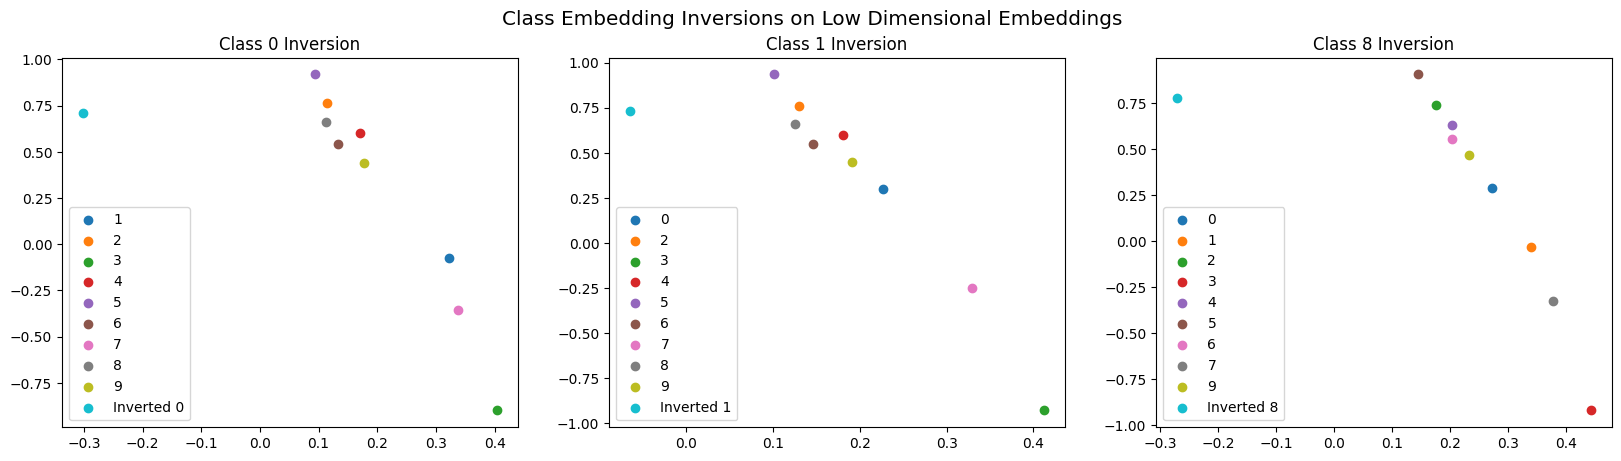

In [12]:
invert_fig: Figure; zero_axes: Axes; one_axes: Axes; eight_axes: Axes
invert_fig, (zero_axes, one_axes, eight_axes) = plt.subplots(1, 3)
invert_fig.suptitle("Class Embedding Inversions on Low Dimensional Embeddings", size='x-large')
invert_fig.set_figwidth(20)
for i in range(zero_invert_emb.shape[0] - 1):
    if i != 0:
        zero_axes.scatter(zero_invert_emb[i, 0], zero_invert_emb[i, 1], label=str(i))
zero_axes.scatter(zero_invert_emb[10, 0], zero_invert_emb[10, 1], label="Inverted 0")
zero_axes.set_title("Class 0 Inversion")
zero_axes.legend(loc='lower left')
for i in range(one_invert_emb.shape[0] - 1):
    if i != 1:
        one_axes.scatter(one_invert_emb[i, 0], one_invert_emb[i, 1], label=str(i))
one_axes.scatter(one_invert_emb[10, 0], one_invert_emb[10, 1], label="Inverted 1")
one_axes.set_title("Class 1 Inversion")
one_axes.legend(loc='lower left')
for i in range(eight_invert_emb.shape[0] - 1):
    if i != 8:
        eight_axes.scatter(eight_invert_emb[i, 0], eight_invert_emb[i, 1], label=str(i))
eight_axes.scatter(eight_invert_emb[10, 0], eight_invert_emb[10, 1], label="Inverted 8")
eight_axes.set_title("Class 8 Inversion")
eight_axes.legend(loc='lower left')
plt.show()

These are some odd results, as it seems like the inversions all seemed to generally gravitate towards the same position in space, and the generated images themselves weren't very successful in terms of reconstructing the desired class. I'm not sure why that happened. More thinking required.

## Next steps?
There are a few possible paths that I want to explore:
- Train a model with an in-the-middle embedding dimension, something between 2D and 256D, and see how its embeddings are organized in space
- Try to perform a similar type of embedding space analysis on a text-conditioned model or on CIFAR-10/MS COCO
- Instead of constructing a matrix as $\begin{bmatrix} a & \cdots & a & b & \cdots & b \end{bmatrix}$, construct it as $\begin{bmatrix} a & b & a & b & \cdots \end{bmatrix}$ to verify the above results. This could be useful as a sanity check, especially for the inversion results, which seem very odd to me.

## Longer Term Goals
It would be very cool to be able to create contours of the embedding space similar to [Visualizing the Loss Landscape](https://proceedings.neurips.cc/paper_files/paper/2018/file/a41b3bb3e6b050b6c9067c67f663b915-Paper.pdf).
- Visualize the landscape of the embedding space using inversion (the landscape that a soft embedding would try to optimize for a particular inversion). That is, we want to calculate the direction of the gradient at a variety of points around the space for a soft embedding being inverted on a particular class.
- Use the locations where certain specific image features arise in the space to map out concepts, although this may be difficult. That is, I could look use CNNs to identify high-level features that are present at hard embeddings. Then, I could sample from soft/random/a linspace of embeddings (and pass them through the same networks) to see how the probability evolves that these features are exhibited in said samples. 
    
    Let's call the probability that a particular feature arises at a particular embedding the "feature presence" for that feature at that embedding. The distribution of feature presences at an embedding could form a metric for how present particular concepts are in the model; that is, if this distribution looks closer to uniform, then the outputs at that embedding would be more inconsistent (combinations of different features) than one with a tighter distribution. A tighter distribution of features, in turn, would consistently output similar combinations of features that could form a concept.